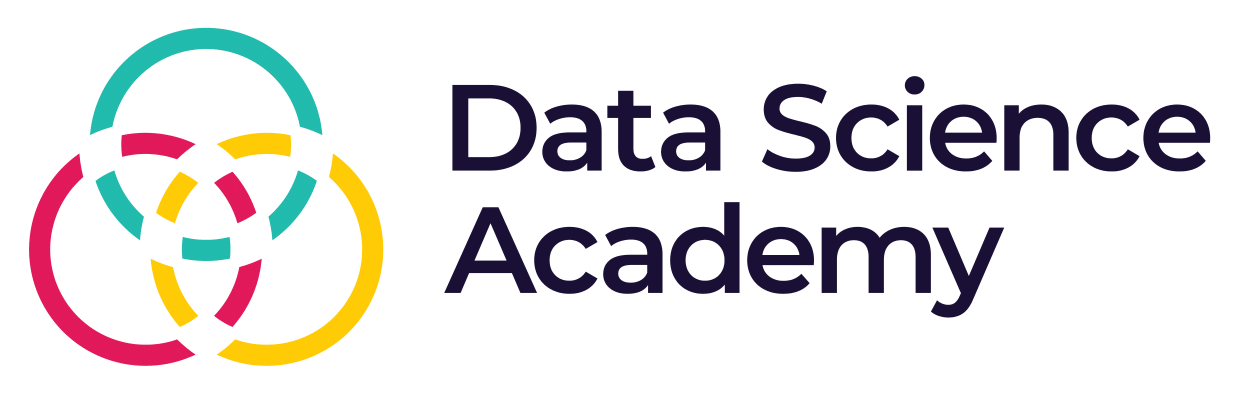

Week 8 | Case Study
=================
#### *Predicting next 7-days 2019-nCoV cumulative Confirmed, Infected, Recovered, Death cases using Linear Regression Model*

You are a Data Scientist working for the World Health Organization (WHO). Due to the outbreak of 2019-nCoV, WHO is alerted to several cases of pneumonia and wants to know how this virus will affect the population, specifically whether the Healthcare System in place is capable of addressing this issue. Therefore, you are tasked to predict the cumulative number of people affected for the next 7-days.

* __Category__: #Tabular data , #Timeseries, #Linear Regression  
* __Dataset__: Novel Corona Virus 2019 Dataset  
* __Dataset Link__: https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset/download

Dataset Desciption:
----------------------------
> __SNo__: *Serial Number*  
> __ObservationDate__: *Observation date in mm/dd/yyyy*  
> __Province/State__: *Province or State*  
> __Country/Region__: *Country or region*  
> __Last Update__: *Last update date time in UTC*  
> __Confirmed__: *Cumulative number of confirmed cases*  
> __Deaths__: *Cumulative number of deaths cases*  
> __Recovered__: *Cumulative number of recovered cases*  
> __*Infected__: *Confirmed - Recovered - Deaths*  


## Imports

In [167]:
import os
import sys
import re

import time
import random
import warnings

import numpy as np
import pandas as pd

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import make_scorer

from matplotlib import pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

pd.options.display.max_columns = 1000
pd.options.display.max_rows = 10000


## Load and Explore The Dataset

In [169]:
covid = pd.read_csv('covid_19_data.csv')

In [170]:
covid.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [171]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6722 entries, 0 to 6721
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   SNo              6722 non-null   int64  
 1   ObservationDate  6722 non-null   object 
 2   Province/State   3956 non-null   object 
 3   Country/Region   6722 non-null   object 
 4   Last Update      6722 non-null   object 
 5   Confirmed        6722 non-null   float64
 6   Deaths           6722 non-null   float64
 7   Recovered        6722 non-null   float64
dtypes: float64(3), int64(1), object(4)
memory usage: 420.2+ KB


In [172]:
covid.describe(include="all")

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
count,6722.000000,6722,3956,6722,6722,6722.000000,6722.000000,6722.000000
unique,NaN,57,276,179,1637,NaN,NaN,NaN
top,NaN,03/18/2020,Gansu,Mainland China,2020-03-11T20:00:00,NaN,NaN,NaN
freq,NaN,284,59,1765,197,NaN,NaN,NaN
mean,3361.500000,NaN,NaN,NaN,NaN,601.195924,19.855846,226.341267
std,1940.618587,NaN,NaN,NaN,NaN,4896.332140,204.486922,2556.035202
min,1.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
25%,1681.250000,NaN,NaN,NaN,NaN,2.000000,0.000000,0.000000
50%,3361.500000,NaN,NaN,NaN,NaN,13.000000,0.000000,0.000000
75%,5041.750000,NaN,NaN,NaN,NaN,108.000000,1.000000,11.000000


In [173]:
covid.dtypes

SNo                int64  
ObservationDate    object 
Province/State     object 
Country/Region     object 
Last Update        object 
Confirmed          float64
Deaths             float64
Recovered          float64
dtype: object

## Preprocessing

In [174]:
# Check for nulls
covid.isnull().sum()

SNo                0   
ObservationDate    0   
Province/State     2766
Country/Region     0   
Last Update        0   
Confirmed          0   
Deaths             0   
Recovered          0   
dtype: int64

In [176]:
# Handle column names
cols = covid.columns
covid.columns = [col.lower() for col in cols]

covid.rename(columns={'observationdate' : 'observation_date', 
                      'country/region' : 'country',
                      'province/state' : 'province',
                      'last update' : 'last_update'}, inplace=True)

covid.head()

,sno,observation_date,province,country,last_update,confirmed,deaths,recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [177]:
sorted(covid.country.unique())

[' Azerbaijan',
 "('St. Martin',)",
 'Afghanistan',
 'Albania',
 'Algeria',
 'Andorra',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Aruba',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Benin',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Brazil',
 'Brunei',
 'Bulgaria',
 'Burkina Faso',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Cayman Islands',
 'Central African Republic',
 'Channel Islands',
 'Chile',
 'Colombia',
 'Congo (Brazzaville)',
 'Congo (Kinshasa)',
 'Costa Rica',
 'Croatia',
 'Cuba',
 'Curacao',
 'Cyprus',
 'Czech Republic',
 'Denmark',
 'Djibouti',
 'Dominican Republic',
 'Ecuador',
 'Egypt',
 'Equatorial Guinea',
 'Estonia',
 'Eswatini',
 'Ethiopia',
 'Faroe Islands',
 'Finland',
 'France',
 'French Guiana',
 'Gabon',
 'Gambia, The',
 'Georgia',
 'Germany',
 'Ghana',
 'Gibraltar',
 'Greece',
 'Greenland',
 'Guadeloupe',
 'Guam',
 'Guatemala',
 'Guernsey',
 'Guinea',
 'Guyana',
 'Holy See',
 'Honduras

In [180]:
# Handle country names
def clean_country(country):
    country = country.lower().strip()
    country = re.sub(r'[^a-z\s]+', '', country)
    country = 'China' if country == 'Mainland China' else country
    return country

covid['country'] = covid['country'].apply(lambda country: clean_country(country))

In [181]:
sorted(covid.country.unique())

['afghanistan',
 'albania',
 'algeria',
 'andorra',
 'antigua and barbuda',
 'argentina',
 'armenia',
 'aruba',
 'australia',
 'austria',
 'azerbaijan',
 'bahrain',
 'bangladesh',
 'barbados',
 'belarus',
 'belgium',
 'benin',
 'bhutan',
 'bolivia',
 'bosnia and herzegovina',
 'brazil',
 'brunei',
 'bulgaria',
 'burkina faso',
 'cambodia',
 'cameroon',
 'canada',
 'cayman islands',
 'central african republic',
 'channel islands',
 'chile',
 'colombia',
 'congo brazzaville',
 'congo kinshasa',
 'costa rica',
 'croatia',
 'cuba',
 'curacao',
 'cyprus',
 'czech republic',
 'denmark',
 'djibouti',
 'dominican republic',
 'ecuador',
 'egypt',
 'equatorial guinea',
 'estonia',
 'eswatini',
 'ethiopia',
 'faroe islands',
 'finland',
 'france',
 'french guiana',
 'gabon',
 'gambia the',
 'georgia',
 'germany',
 'ghana',
 'gibraltar',
 'greece',
 'greenland',
 'guadeloupe',
 'guam',
 'guatemala',
 'guernsey',
 'guinea',
 'guyana',
 'holy see',
 'honduras',
 'hong kong',
 'hungary',
 'iceland',


In [187]:
# Check if the number of cases per country increases monotonically as time passes by, if not, fix it
def check_monotonic_increasing(grp):
    if np.sum(np.diff(grp) < 0) > 0:
        return False
    else:
        return True
    
def force_monotonic_increasing(grp):
    if np.sum(np.diff(grp) < 0) > 0:
        return sorted(grp)
    else:
        return grp
    


In [188]:
covid.head()

,sno,observation_date,province,country,last_update,confirmed,deaths,recovered
0,1,01/22/2020,Anhui,mainland china,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,mainland china,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,mainland china,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,mainland china,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,mainland china,1/22/2020 17:00,0.0,0.0,0.0


In [193]:
group_country_date = covid.groupby(by=['country', 'observation_date']).agg({'confirmed': 'sum', 'deaths': 'sum', 'recovered': 'sum'}).sort_values(by=['country', 'observation_date'], ascending=[True, True])
group_country = group_country_date.reset_index(level=1, drop=True)
country_date_scores = group_country_date.reset_index()
country_scores = group_country.reset_index()
country_scores.head()

,country,confirmed,deaths,recovered
0,afghanistan,1.0,0.0,0.0
1,afghanistan,1.0,0.0,0.0
2,afghanistan,1.0,0.0,0.0
3,afghanistan,1.0,0.0,0.0
4,afghanistan,1.0,0.0,0.0


In [194]:
monitor = country_scores.groupby(by=['country']).transform(lambda grp: check_monotonic_increasing(grp))
monitor = monitor.apply(lambda x: x['confirmed'] and x['deaths'] and x['recovered'], axis=1)
non_monotonic_increase = country_scores.iloc[np.where(monitor == False)]
print(non_monotonic_increase.country.unique())
non_monotonic_increase


['andorra' 'australia' 'austria' 'azerbaijan' 'bahrain' 'egypt' 'guam'
 'guernsey' 'hong kong' 'iceland' 'iraq' 'italy' 'japan' 'jersey'
 'lebanon' 'montenegro' 'occupied palestinian territory' 'others'
 'puerto rico' 'republic of the congo' 'russia' 'saint barthelemy'
 'south korea' 'the gambia']


,country,confirmed,deaths,recovered
57,andorra,1.0,0.0,0.0
58,andorra,1.0,0.0,0.0
59,andorra,1.0,0.0,0.0
60,andorra,1.0,0.0,0.0
61,andorra,1.0,0.0,0.0
62,andorra,1.0,0.0,0.0
63,andorra,1.0,0.0,0.0
64,andorra,1.0,0.0,0.0
65,andorra,1.0,0.0,0.0
66,andorra,1.0,0.0,0.0


In [195]:
monitor = country_scores.groupby(by=['country']).transform(lambda grp: force_monotonic_increasing(grp))
country_scores[monitor.columns] = monitor.values
country_scores.head()

,country,confirmed,deaths,recovered
0,afghanistan,1.0,0.0,0.0
1,afghanistan,1.0,0.0,0.0
2,afghanistan,1.0,0.0,0.0
3,afghanistan,1.0,0.0,0.0
4,afghanistan,1.0,0.0,0.0


In [126]:
country_date_scores[country_scores.columns] = country_scores.values

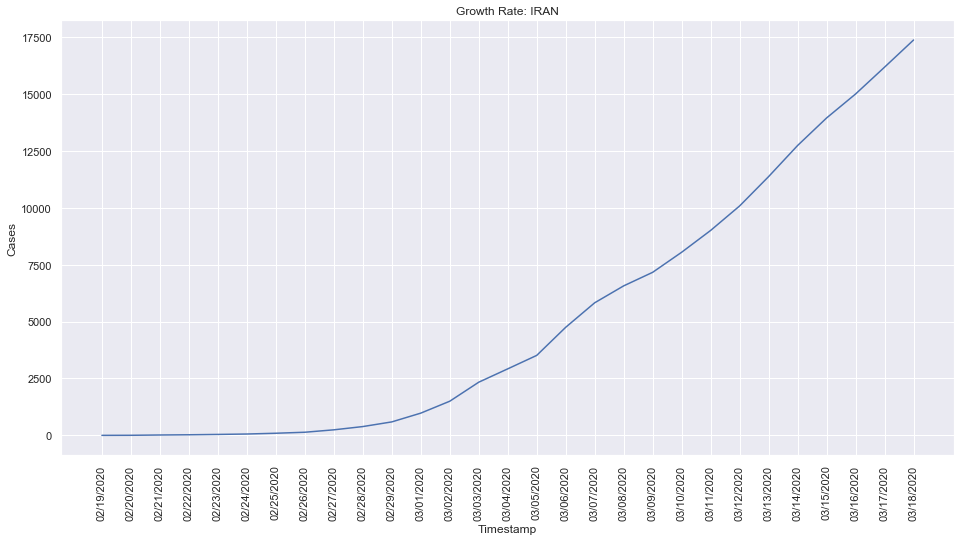

In [196]:
# Plot growth rate for an Area of Interest
area_of_interest = 'iran'
y_data = country_date_scores.loc[country_date_scores.country == area_of_interest, 'confirmed']
x_data = country_date_scores.loc[country_date_scores.country == area_of_interest, 'observation_date']

plt.subplots(1, 1, figsize=(16, 8))
plt.plot(x_data, y_data)
plt.xlabel("Timestamp")
plt.ylabel("Cases")
plt.title(f"Growth Rate: {area_of_interest.upper()}")
plt.xticks(rotation=90)
plt.show()

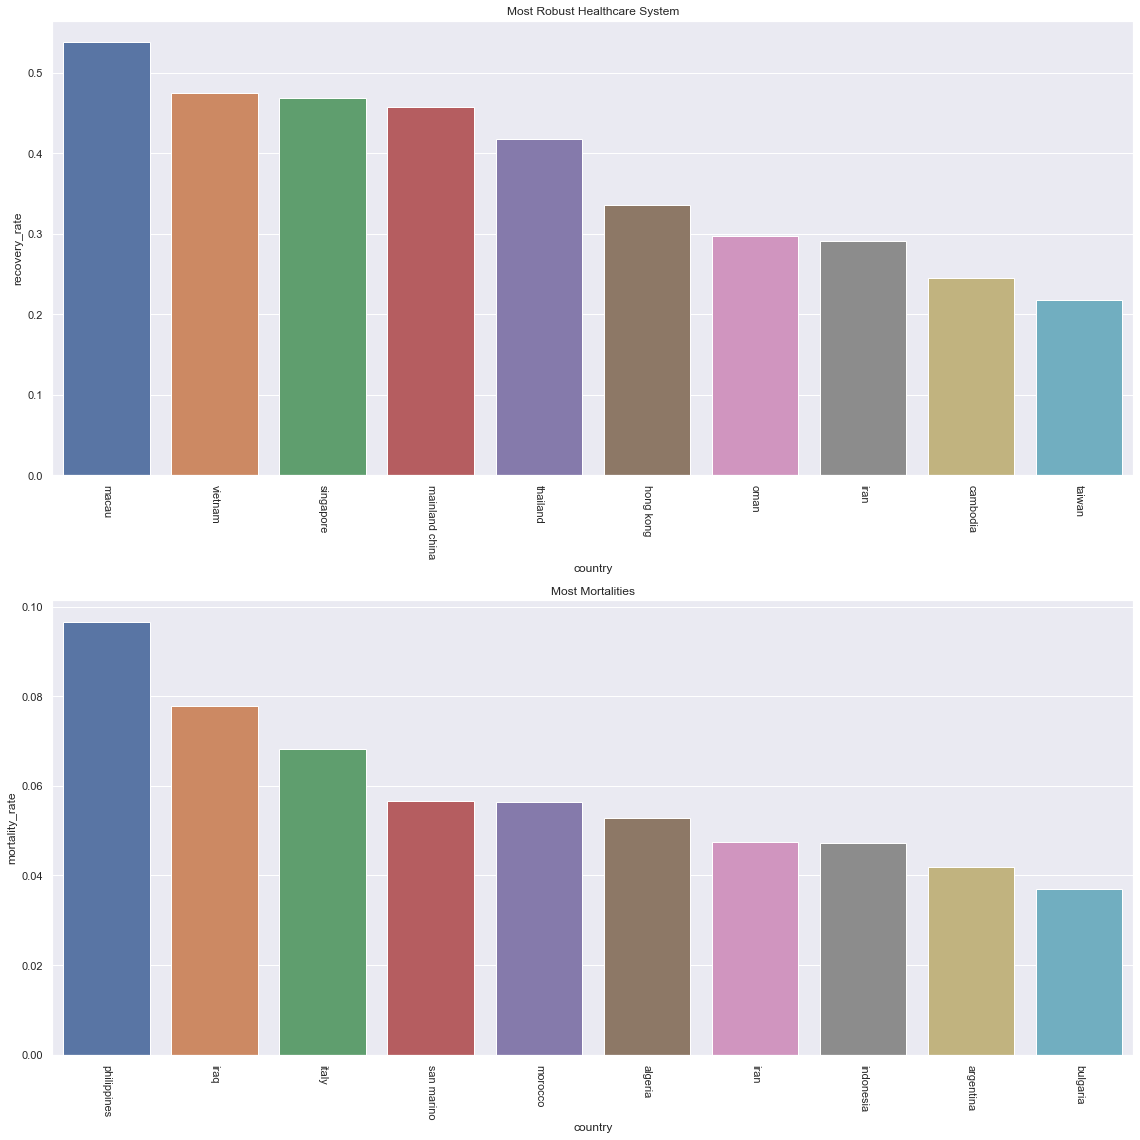

In [134]:
# Most robust healthcare system
# Most mortalities

group_country_scores = country_scores.groupby(by=['country']).agg({'confirmed': 'sum', 'deaths': 'sum', 'recovered': 'sum'})
group_country_scores['recovery_rate'] = group_country_scores['recovered'] / group_country_scores['confirmed']
group_country_scores['mortality_rate'] = group_country_scores['deaths'] / group_country_scores['confirmed']

fig, axes = plt.subplots(2, 1, figsize=(16, 16))

recovery_df = group_country_scores.loc[group_country_scores['confirmed'] > 100, ['recovery_rate']].sort_values(by=['recovery_rate'], ascending=False).head(10)
sns.barplot(x=recovery_df.index, y="recovery_rate", data=recovery_df, ax=axes[0])
axes[0].set_title("Most Robust Healthcare System")
axes[0].xaxis.set_tick_params(rotation=270)

mortality_df = group_country_scores.loc[group_country_scores['confirmed'] > 100, ['mortality_rate']].sort_values(by=['mortality_rate'], ascending=False).head(10)
sns.barplot(x=mortality_df.index, y="mortality_rate", data=mortality_df, ax=axes[1])
axes[1].set_title("Most Mortalities")
axes[1].xaxis.set_tick_params(rotation=270)

fig.tight_layout()
plt.show()

In [197]:
# Check if confirmed cases are greater or equal to the sum of death and recovered cases combined
country_date_scores['check_sum'] = country_date_scores.apply(lambda x: True if x['confirmed'] >= (x['deaths'] + x['recovered']) else False, axis=1)
print(np.sum(~country_date_scores['check_sum']))
country_date_scores.drop(['check_sum'], axis=1, inplace=True)

0


In [140]:
# Convert observation_date to pandas datetime format for further processing
# country_date_scores['observation_date'] = pd.to_datetime(country_date_scores['observation_date'])
country_date_scores['observation_date'] = country_date_scores['observation_date'].map(pd.to_datetime)

In [141]:
date_scores = country_date_scores.groupby(by=['observation_date']).agg({'confirmed': 'sum', 'deaths': 'sum', 'recovered': 'sum'}).reset_index()

In [142]:
# Calculate days_since
country_date_scores['observation_date'] = country_date_scores['observation_date'].map(pd.to_datetime)
date_scores['days_since'] = (date_scores['observation_date'] - date_scores['observation_date'].min()).dt.days

In [198]:
# Check if days_since increases monotonically
assert np.sum(np.diff(date_scores['days_since']) < 0) == 0

In [144]:
# Calculate infected/active cases
date_scores['infected'] = date_scores['confirmed'] - (date_scores['recovered'] + date_scores['deaths'])

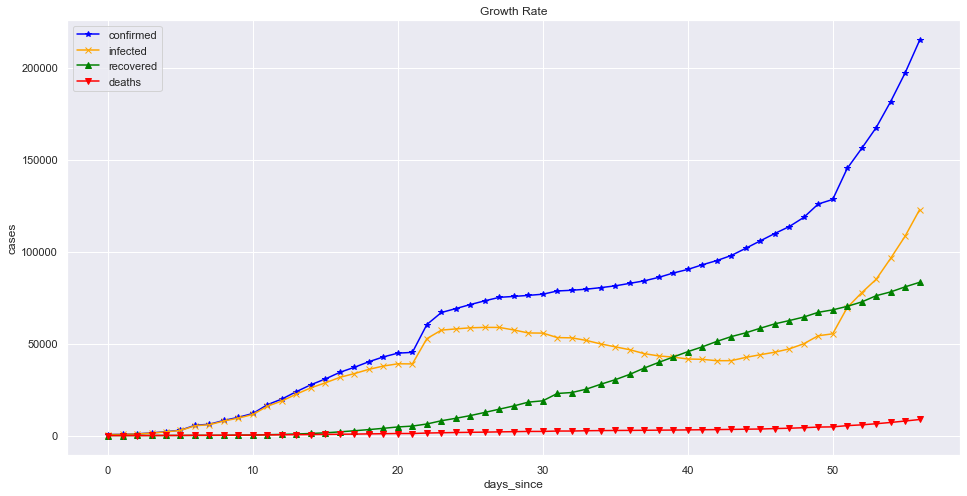

In [145]:
plt.subplots(1, 1, figsize=(16, 8))
plt.plot(date_scores['days_since'], date_scores['confirmed'], label='confirmed', marker='*', color='blue')
plt.plot(date_scores['days_since'], date_scores['infected'], label='infected', marker='x', color='orange')
plt.plot(date_scores['days_since'], date_scores['recovered'], label='recovered', marker='^', color='green')
plt.plot(date_scores['days_since'], date_scores['deaths'], label='deaths', marker='v', color='red')
plt.xlabel("days_since")
plt.ylabel("cases")
plt.title("Growth Rate")
plt.legend(loc='upper left')

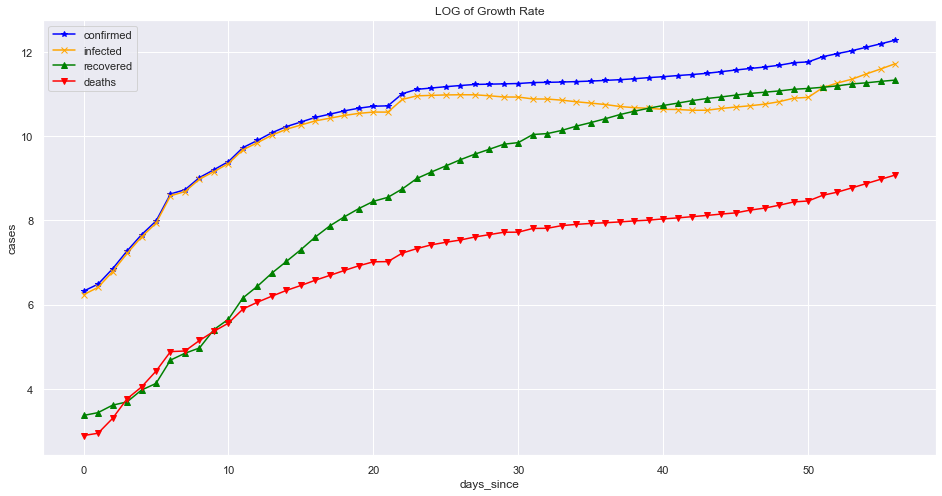

In [147]:
# Better idea?
# Linearization of curves may help to get better performance over the exponential segment
# If you are doing this, make sure that you also inverse the log function when predicting
# log1p is reverse of exp(x) – 1.
plt.subplots(1, 1, figsize=(16, 8))
plt.plot(date_scores['days_since'], np.log1p(date_scores['confirmed']), label='confirmed', marker='*', color='blue')
plt.plot(date_scores['days_since'], np.log1p(date_scores['infected']), label='infected', marker='x', color='orange')
plt.plot(date_scores['days_since'], np.log1p(date_scores['recovered']), label='recovered', marker='^', color='green')
plt.plot(date_scores['days_since'], np.log1p(date_scores['deaths']), label='deaths', marker='v', color='red')
plt.xlabel("days_since")
plt.ylabel("cases")
plt.title("LOG of Growth Rate")
plt.legend(loc='upper left')

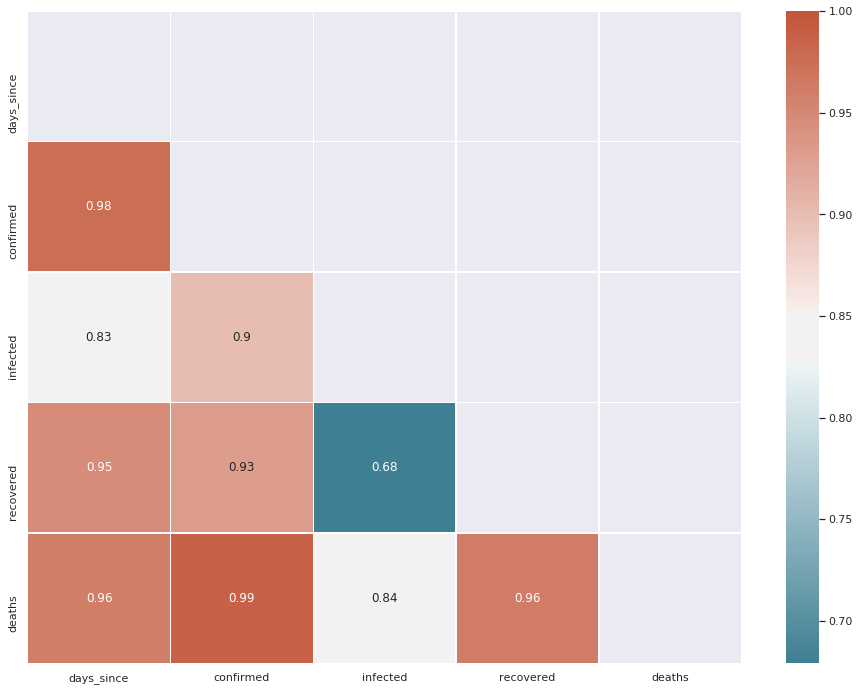

In [29]:
# Correlations

# Set up figure
fig, ax = plt.subplots(figsize=(16, 12))

# Create correlation dataframe
df_corr = date_scores[['days_since', 'confirmed', 'infected', 'recovered', 'deaths']]

# Create correlation matrix
corr = df_corr.corr()

# # Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)

# Plot correlation matrix without the diagonal and upper part
sns.heatmap(corr, mask=mask, cmap=cmap, annot=True, linewidths=.5)

Modeling
========

In [148]:
date_scores.head()

,observation_date,confirmed,deaths,recovered,days_since,infected
0,2020-01-22,554.0,17.0,28.0,0,509.0
1,2020-01-23,654.0,18.0,30.0,1,606.0
2,2020-01-24,941.0,26.0,36.0,2,879.0
3,2020-01-25,1438.0,42.0,39.0,3,1357.0
4,2020-01-26,2118.0,56.0,52.0,4,2010.0


In [199]:
# Train/Test Split

# train + validation interval: '2020-01-22':'2020-03-09'
# test interval:  '2020-03-10':'2020-03-16'

X_columns = ['days_since']

# Change y_column to one of ('confirmed', 'infected', 'recovered', 'deaths')
# and re-run this cell and cells below
y_column = ['confirmed'] 
    
X_train = date_scores.loc[date_scores['observation_date'] < '2020-03-10', X_columns]
X_test = date_scores.loc[date_scores['observation_date'] >= '2020-03-10', X_columns]
y_train = date_scores.loc[date_scores['observation_date'] < '2020-03-10', y_column]
y_test = date_scores.loc[date_scores['observation_date'] >= '2020-03-10', y_column]

In [200]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()  
regressor.fit(X_train, y_train) #training the algorithm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [201]:
#To retrieve the intercept:
print(regressor.intercept_)
#For retrieving the slope:
print(regressor.coef_)

[-5375.16751701]
[[2539.01156101]]


In [202]:
test_scores = pd.DataFrame()
test_scores['y_true'] = y_test.values.flatten()
test_scores['y_pred'] = regressor.predict(X_test).flatten()
test_scores

,y_true,y_pred
0,118575.0,116497.387411
1,125868.0,119036.398972
2,128352.0,121575.410533
3,145208.0,124114.422094
4,156105.0,126653.433655
5,167421.0,129192.445216
6,181582.0,131731.456777
7,197204.0,134270.468338
8,214927.0,136809.479899


Results
========

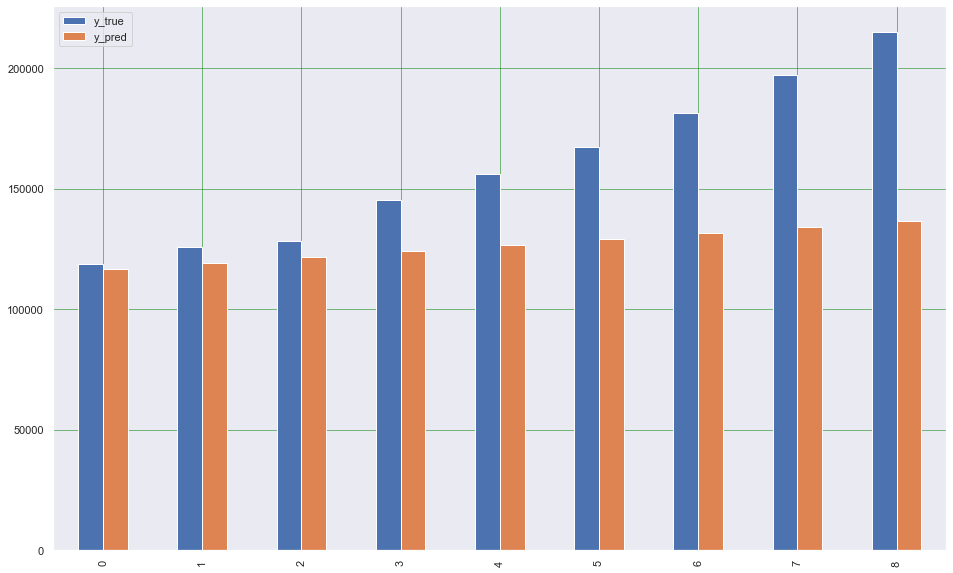

In [162]:
df1 = test_scores.copy()
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [203]:
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(test_scores['y_true'], test_scores['y_pred']))  
print('Mean Squared Error:', metrics.mean_squared_error(test_scores['y_true'], test_scores['y_pred']))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_scores['y_true'], test_scores['y_pred'])))
print('Test R2: ', {r2_score(test_scores['y_true'], test_scores['y_pred'])})

Mean Absolute Error: 32817.89967795631
Mean Squared Error: 1713190957.2203095
Root Mean Squared Error: 41390.711001628246
Test R2:  {-0.706356854683327}


Conclusion
===========

Linear Regression will undergo performance degradation when underlying relationships between the predictor and target variables are not linear. Therefore, linear models can only be a very coarse estimate of the reality. For more sophisticated predictions on complex data non-linear models e.g. RandomForest, XGBoost, LightGBM, CatBoost, Neural Networks, non-linear SVM etc. can be utilized. Ensemble of well-performing models (stacking/blending) with smart cross-validation strategy is expected to further increase the score.